targets.shape=(900, 2)


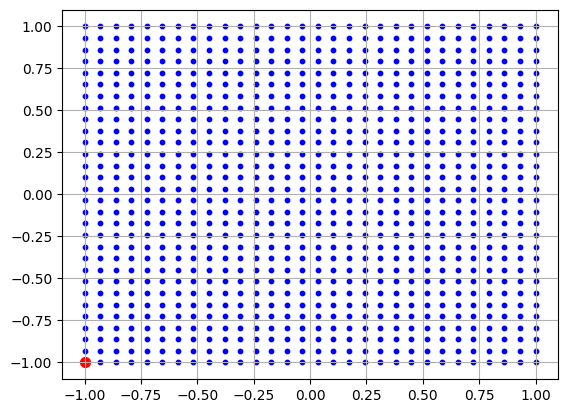

In [36]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = int(16)
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(30)
# Choose the redundancy parameter (have each target be visited by exactly that many robots)
rp = min(3, k)

# Fuel Capacity Parameters
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 4.  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = range(len(targets))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1,
# ])
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# print(f"{depots=}")
# depots = np.concatenate((depots, depots))
depot_indices = range(len(targets), len(targets)+len(depots))

nodes = np.concatenate((targets, depots))
# print(f"{nodes.shape=}")
node_indices = range(len(targets)+len(depots))

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [37]:
import itertools

# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i, j in itertools.product(node_indices, node_indices):
    cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
    # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")
print(f"{cost.shape=}")


cost.shape=(901, 901)


In [38]:
import datetime


def visualize_paths_brute_force(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        for i, j in itertools.product(node_indices, node_indices):
            if edges[ki][i][j] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i, 0], nodes[i, 1], c="purple", s=8)
                ax.scatter(nodes[j, 0], nodes[j, 1], c="purple", s=8)
                ax.plot([nodes[i, 0], nodes[j, 0]], [nodes[i, 1], nodes[j, 1]], color="purple", linewidth=1)
        
        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()
    
    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)
    
    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    fig.savefig(f"../../data/yasars_heuristic_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png") 
    plt.show()

def visualize_subtours_brute_force(subtours):
    path_edges = np.zeros((k, len(node_indices), len(node_indices)), dtype=np.uint8)

    for ki in range(k):
        for subtour_i, subtour in enumerate(subtours[ki]):
            for curr_node_i in range(len(subtour) - 1):
                next_node_i = curr_node_i + 1
                curr_node = subtour[curr_node_i]
                next_node = subtour[next_node_i]
                path_edges[ki][curr_node][next_node] = 1
    
    visualize_paths_brute_force(path_edges)

all_subtours.shape=(900, 3)


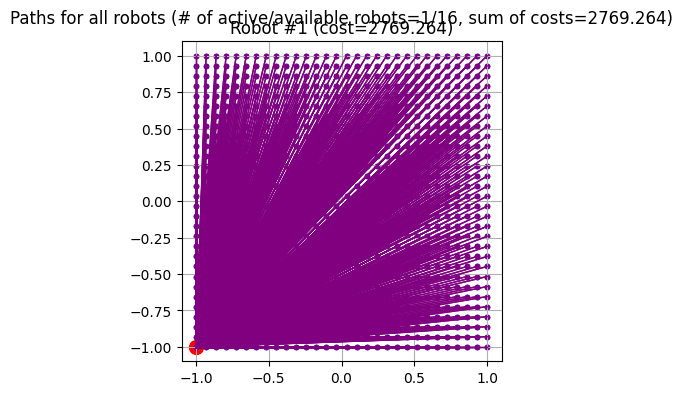

In [39]:
# Initialize a very inefficient list of subtours
all_subtours = np.array([[depot_indices[0], target_indices[target_i], depot_indices[0]] for target_i in target_indices])
# all_subtours = [[depot_indices[0], target_indices[0], depot_indices[0]],
#                 [depot_indices[0], target_indices[1], depot_indices[0]],
#                     ...
#                 ]
print(f"{all_subtours.shape=}")

# Assign all subtours to the first robot for now.
robot_subtours = [ [] for _ in range(k) ]
robot_subtours[0].extend(all_subtours)

visualize_subtours_brute_force(robot_subtours)

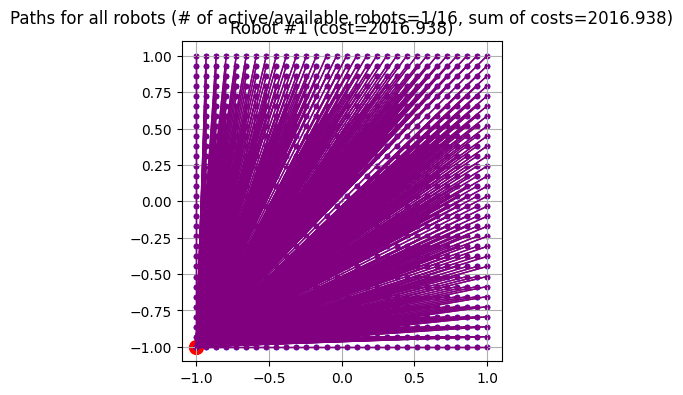

In [40]:
# Initialize a slightly more efficient list of subtours

import heapq
from pprint import pprint as pp


all_subtours = []

collinear_targets = {}
for target_i in target_indices:
    v1 = nodes[target_i]
    v2 = nodes[depot_indices[0]]
    angle = np.arctan2(*(v1 - v2)) % (2 * np.pi)
    dist = float(np.linalg.norm(nodes[target_i]-nodes[depot_indices[0]]))
    
    is_target_on_collinear_targets = False
    for target_angle in collinear_targets.keys():
        if np.isclose(target_angle, angle):
            is_target_on_collinear_targets = True
            heapq.heappush(collinear_targets[target_angle], (dist, target_i))
            # print(f"\tAdding to {angle=}: {collinear_targets[target_angle]=}")
            break
    if not is_target_on_collinear_targets:
        collinear_targets[angle] = []
        heapq.heappush(collinear_targets[angle], (dist, target_i))
        # print(f"\tCreating a new one at {angle=}: {collinear_targets[angle]=}")

# pp(collinear_targets)
for _, target_queue in collinear_targets.items():
    new_subtour = [depot_indices[0]]
    while target_queue:
        _, target_i = heapq.heappop(target_queue)
        new_subtour.append(target_i)
    new_subtour.append(depot_indices[0])
    all_subtours.append(new_subtour)
# pp(all_subtours)

# Assign all subtours to the first robot for now.
robot_subtours = [ [] for _ in range(k) ]
robot_subtours[0].extend(all_subtours)

visualize_subtours_brute_force(robot_subtours)

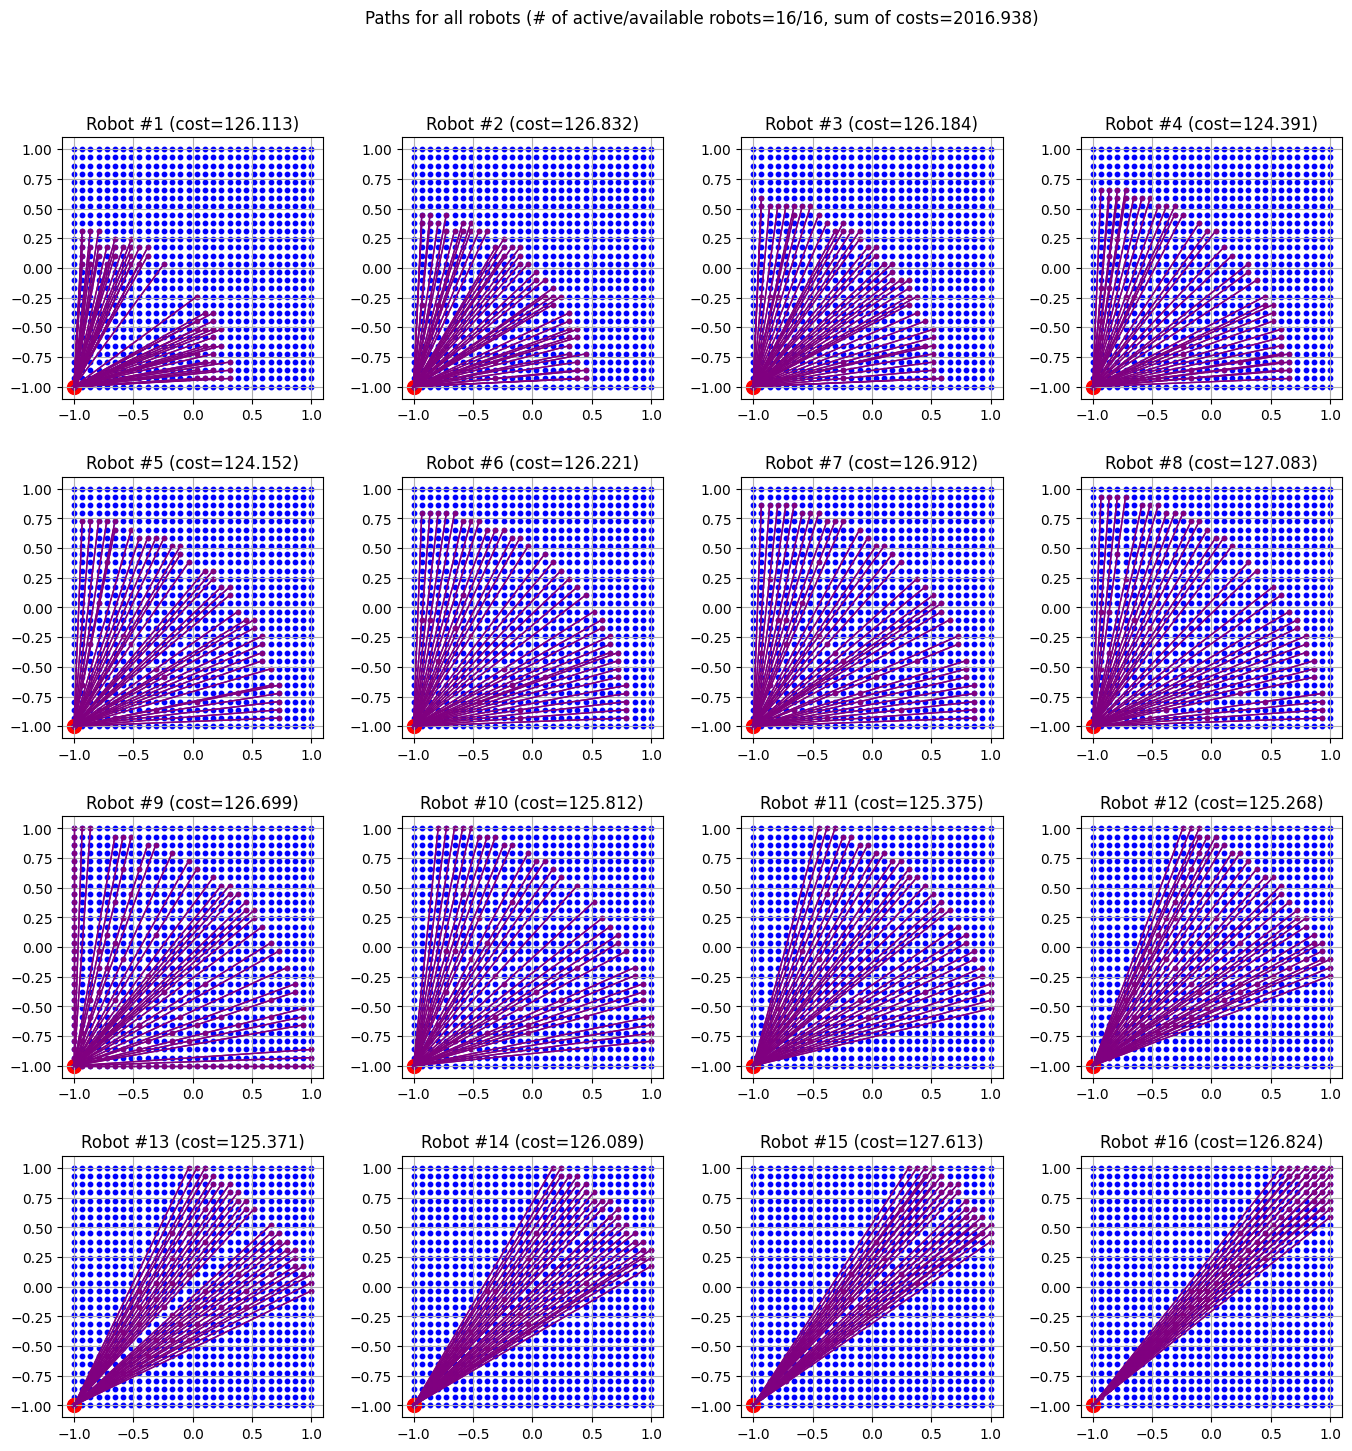

In [41]:
# pp(all_subtours)
# print(f"{len(all_subtours)=}")
from bisect import bisect_left


all_subtours_cost = []
for subtour in all_subtours:
    subtour_cost = 0
    curr_node = subtour[0]
    for next_node in subtour[1:]:
        subtour_cost += np.sqrt((nodes[curr_node,0]-nodes[next_node,0]) ** 2 + (nodes[curr_node,1]-nodes[next_node,1]) ** 2)
        curr_node = next_node
    all_subtours_cost.append(subtour_cost)
# pp(all_subtours_cost)
all_subtours_cost = np.array(all_subtours_cost)
# print(f"{all_subtours_cost=}")

all_subtours_cost_sorted_indices = all_subtours_cost.argsort()
# print(f"{all_subtours_cost_sorted_indices=}")

# print(f"{all_subtours_cost[all_subtours_cost_sorted_indices]=}")


# https://takeuforward.org/arrays/split-array-largest-sum/
def countPartitions(a, maxSum):
    # n = len(a)  # size of array
    partitions = 1
    subarraySum = 0
    partitions_array = [[]]
    # partitions_max_array = []
    for i in all_subtours_cost_sorted_indices:
        if subarraySum + a[i] <= maxSum:
            # insert element to current subarray
            subarraySum += a[i]
        else:
            # partitions_max_array.append(subarraySum)
            # insert element to next subarray
            partitions += 1
            subarraySum = a[i]
            partitions_array.append([])
        partitions_array[partitions-1].append(i)

    return partitions, partitions_array  #, partitions_max_array

def largestSubarraySumMinimized(a, k):
    low = max(a)
    high = sum(a)

    for maxSum in np.linspace(low, high, num=int(np.ceil((high - low)/0.01))):
    # for maxSum in range(low, high+1):
        p, p_a = countPartitions(a, maxSum)
        if p == k:
            return p_a
    return None

distributed_subtours_indices = largestSubarraySumMinimized(all_subtours_cost, k)
# print(f"{distributed_subtours_indices=}")

distributed_subtours = []
for distributed_subtours_i in distributed_subtours_indices:
    robot_subtours = []
    for subtour_i in distributed_subtours_i:
        robot_subtours.append(all_subtours[subtour_i])
    distributed_subtours.append(robot_subtours)

# pp(distributed_subtours)

visualize_subtours_brute_force(distributed_subtours)


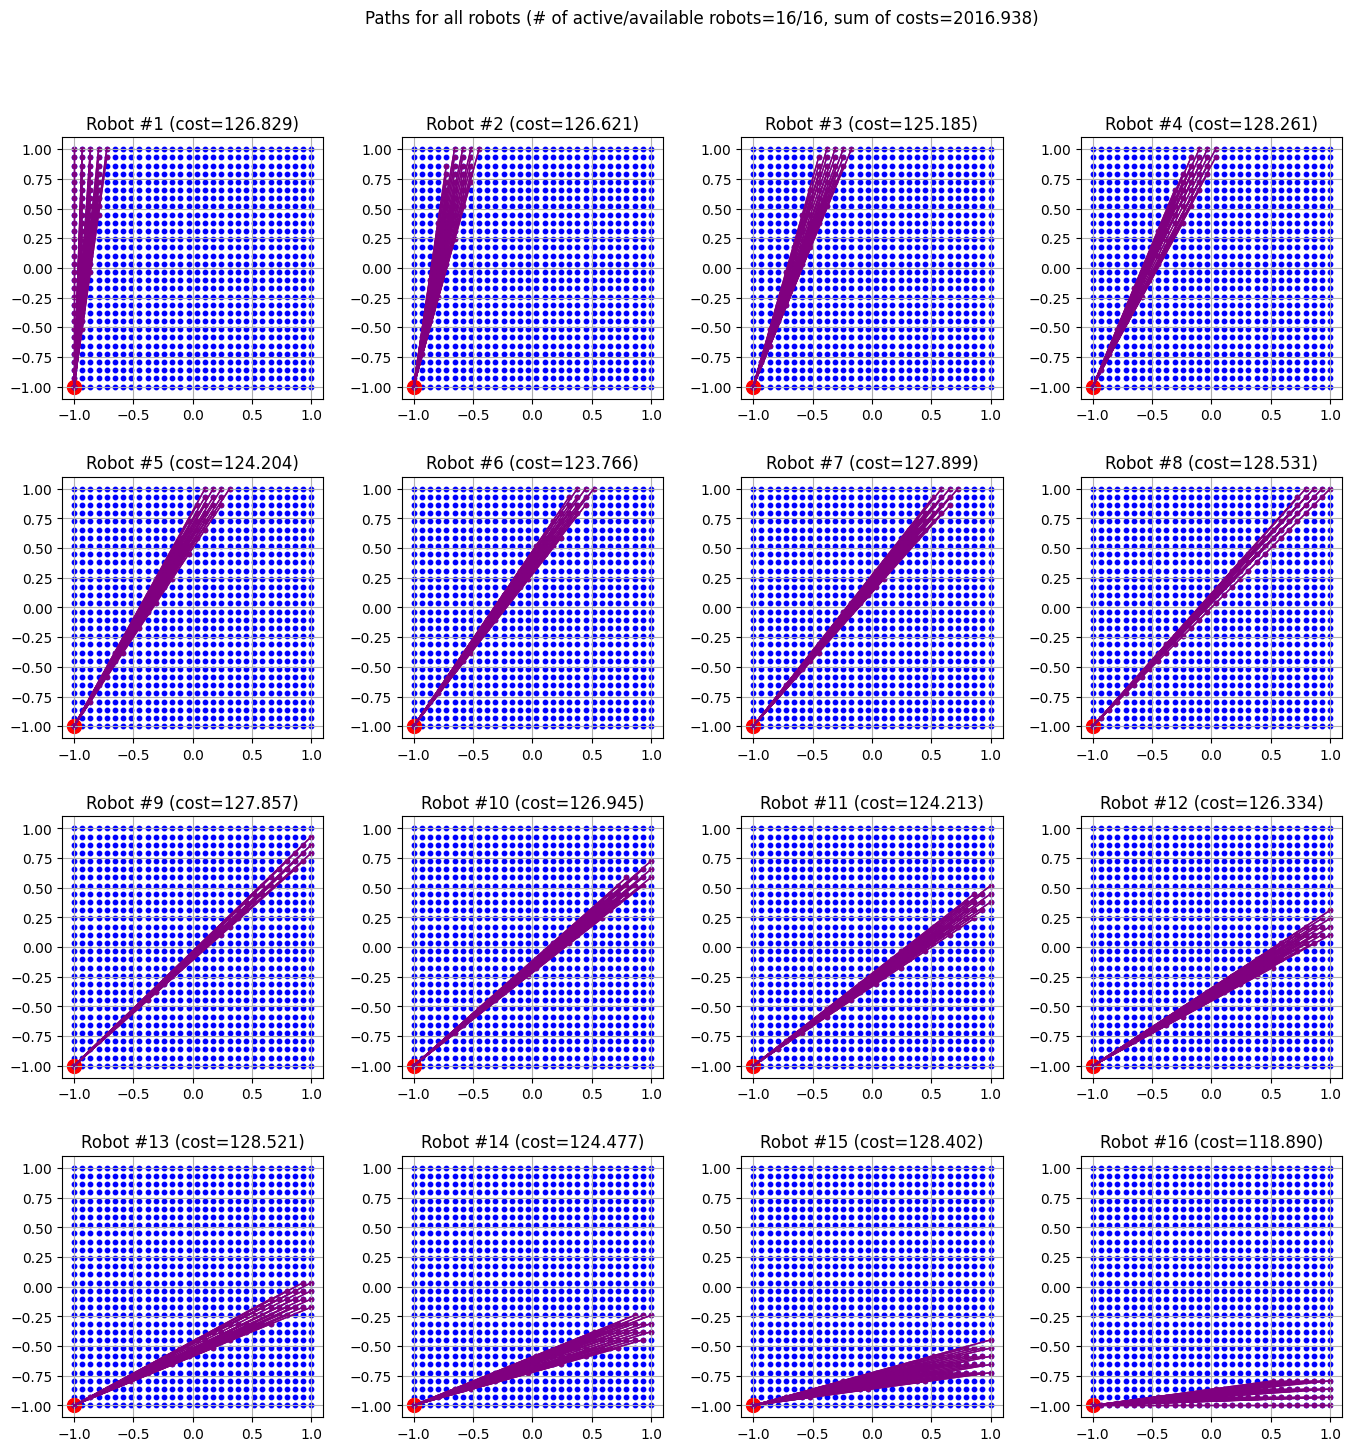

In [42]:
# Still use the subtour cost to assign, but use an ordering based on angle/heading to prefer directionality
angle_values = []
all_subtours_cost = []
for subtour in all_subtours:
    v1 = nodes[subtour[1]]
    v2 = nodes[depot_indices[0]]
    angle = np.arctan2(*(v1 - v2)) % (2 * np.pi)
    angle_values.append(angle)
    
    subtour_cost = 0
    curr_node = subtour[0]
    for next_node in subtour[1:]:
        subtour_cost += np.sqrt((nodes[curr_node,0]-nodes[next_node,0]) ** 2 + (nodes[curr_node,1]-nodes[next_node,1]) ** 2)
        curr_node = next_node
    all_subtours_cost.append(subtour_cost)

angle_values = np.array(angle_values)
all_subtours_cost = np.array(all_subtours_cost)

angle_sorted_indices = angle_values.argsort()


# https://takeuforward.org/arrays/split-array-largest-sum/
def countPartitions(a, maxSum):
    # n = len(a)  # size of array
    partitions = 1
    subarraySum = 0
    partitions_array = [[]]
    # partitions_max_array = []
    for i in angle_sorted_indices:
        if subarraySum + a[i] <= maxSum:
            # insert element to current subarray
            subarraySum += a[i]
        else:
            # partitions_max_array.append(subarraySum)
            # insert element to next subarray
            partitions += 1
            subarraySum = a[i]
            partitions_array.append([])
        partitions_array[partitions-1].append(i)

    return partitions, partitions_array  #, partitions_max_array

def largestSubarraySumMinimized(a, k):
    low = max(a)
    high = sum(a)

    for maxSum in np.linspace(low, high, num=int(np.ceil((high - low)/0.01))):
    # for maxSum in range(low, high+1):
        p, p_a = countPartitions(a, maxSum)
        if p == k:
            return p_a
    return None

distributed_subtours_indices = largestSubarraySumMinimized(all_subtours_cost, k)
# print(f"{distributed_subtours_indices=}")

distributed_subtours = []
for distributed_subtours_i in distributed_subtours_indices:
    robot_subtours = []
    for subtour_i in distributed_subtours_i:
        robot_subtours.append(all_subtours[subtour_i])
    distributed_subtours.append(robot_subtours)

# pp(distributed_subtours)

visualize_subtours_brute_force(distributed_subtours)


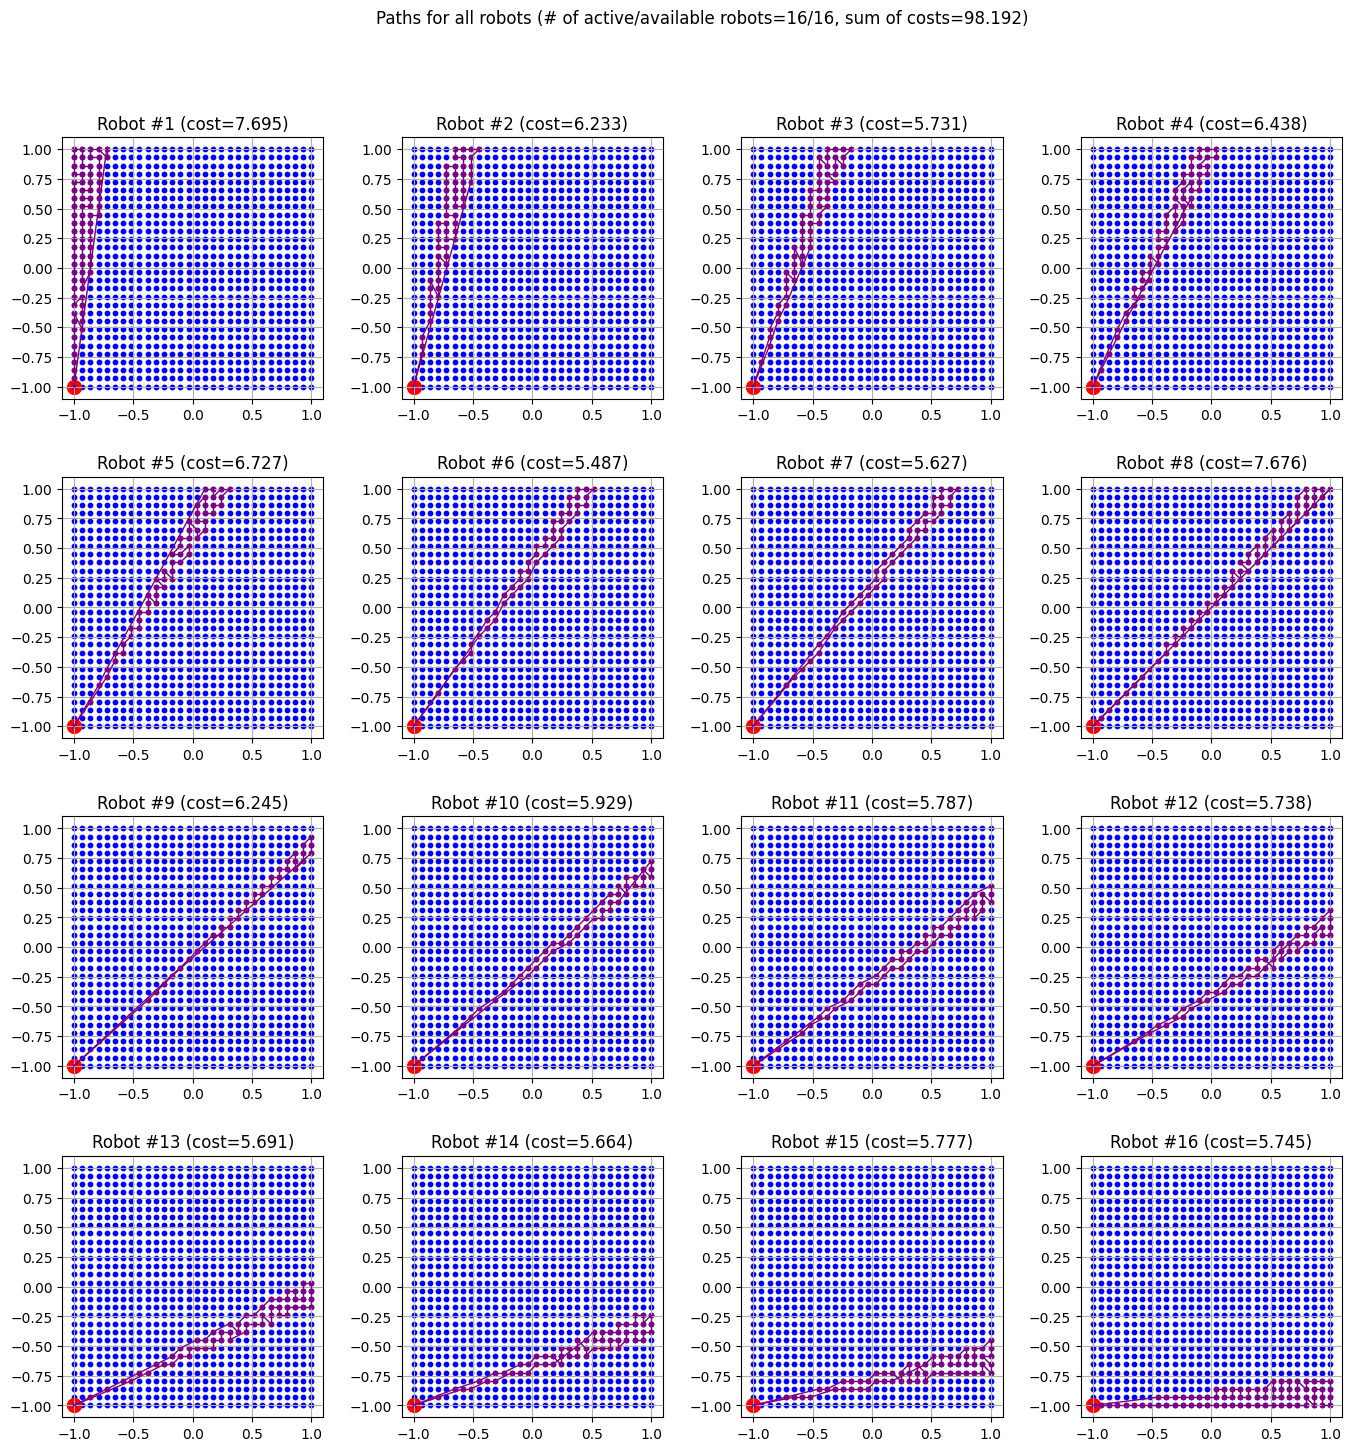

In [43]:
# Still use the subtour cost to assign, but use an ordering based on angle/heading to prefer directionality
angle_values = []
all_subtours_cost = []
for subtour in all_subtours:
    v1 = nodes[subtour[1]]
    v2 = nodes[depot_indices[0]]
    angle = np.arctan2(*(v1 - v2)) % (2 * np.pi)
    angle_values.append(angle)
    
    subtour_cost = 0
    curr_node = subtour[0]
    for next_node in subtour[1:]:
        subtour_cost += np.sqrt((nodes[curr_node,0]-nodes[next_node,0]) ** 2 + (nodes[curr_node,1]-nodes[next_node,1]) ** 2)
        curr_node = next_node
    all_subtours_cost.append(subtour_cost)

angle_values = np.array(angle_values)
all_subtours_cost = np.array(all_subtours_cost)

angle_sorted_indices = angle_values.argsort()


# https://takeuforward.org/arrays/split-array-largest-sum/
def countPartitions(a, maxSum):
    # n = len(a)  # size of array
    partitions = 1
    subarraySum = 0
    partitions_array = [[]]
    # partitions_max_array = []
    for i in angle_sorted_indices:
        if subarraySum + a[i] <= maxSum:
            # insert element to current subarray
            subarraySum += a[i]
        else:
            # partitions_max_array.append(subarraySum)
            # insert element to next subarray
            partitions += 1
            subarraySum = a[i]
            partitions_array.append([])
        partitions_array[partitions-1].append(i)

    return partitions, partitions_array  #, partitions_max_array

def largestSubarraySumMinimized(a, k):
    low = max(a)
    high = sum(a)

    for maxSum in np.linspace(low, high, num=int(np.ceil((high - low)/0.01))):
    # for maxSum in range(low, high+1):
        p, p_a = countPartitions(a, maxSum)
        if p == k:
            return p_a
    return None

distributed_subtours_indices = largestSubarraySumMinimized(all_subtours_cost, k)
# print(f"{distributed_subtours_indices=}")

distributed_subtours = []
for distributed_subtours_i in distributed_subtours_indices:
    robot_subtours = []
    for subtour_i in distributed_subtours_i:
        robot_subtours.append(all_subtours[subtour_i])
    distributed_subtours.append(robot_subtours)

# pp(distributed_subtours)

def calculate_total_distance(path, cost_matrix):
    total_cost = 0
    for i in range(len(path) - 1):
        total_cost += cost_matrix[path[i], path[i + 1]]
    total_cost += cost_matrix[path[-1], path[0]]  # Return to start
    return total_cost

def k_opt(route, cost_matrix, ki):
    best_distance = calculate_total_distance(route, cost_matrix)
    best_route = route.copy()

    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 1):
            for j in range(i + 1, len(route)):
                if j - i < ki - 1:
                    continue  # Ensure the segment size is at least k

                new_route = route.copy()
                new_route[i:j] = reversed(route[i:j])  # Reverse the segment between i and j

                new_distance = calculate_total_distance(new_route, cost_matrix)

                if new_distance < best_distance:
                    best_distance = new_distance
                    best_route = new_route.copy()
                    improved = True

        route = best_route.copy()

    best_route.append(best_route[0])
    return best_route, calculate_total_distance(best_route, cost_matrix)

optimized_subtours = []
for ki in range(len(distributed_subtours)):
    subtour_nodes = set()
    for subtour in distributed_subtours[ki]:
        subtour_nodes = subtour_nodes.union(set(subtour))
    subtour_nodes = list(subtour_nodes)
    
    subtour, subtour_dist = k_opt(subtour_nodes, cost, 2)
    optimized_subtours.append([subtour])


visualize_subtours_brute_force(optimized_subtours)